In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = pd.read_csv('/content/ner_dataset.csv',encoding = 'latin1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
data = data.fillna(method = 'ffill')

In [4]:
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
795564,Sentence: 36366,DC,NNP,O
795565,Sentence: 36366,",",",",O
795566,Sentence: 36366,has,VBZ,O
795567,Sentence: 36366,partnered,VBN,O


In [5]:
import tqdm

def sentence_integrate(data):
  agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                     s["POS"].values.tolist(),
                                                     s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()

sentences = sentence_integrate(data) #creates a list of tuples for each sentence. The tuples contain each token in the sentence along with the pos and the tag of the token



In [6]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [7]:
len(sentences)

36366

In [8]:
words = data['Word'].unique().tolist()
words.append('ENDPAD')
tags = data['Tag'].unique().tolist()
tags_count = len(tags)
words_count = len(words)

In [9]:
print(tags) #these are the tags we want tthe model to classify the tokens into

['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve', 'I-eve', 'I-nat']


In [10]:
#simple mapping of word and tag to their indices
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [11]:
tag2idx

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [12]:
#padding/truncating all the sentences to be of the same length because model expects all inputs to be of same length.
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

# extract sentence words
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=words_count-1)

# extract sentence tags
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

#X and y are 2d matrices which hold the index representation of the words in each sentecne and the Tag associated with each token in the sentence

In [13]:
(X[0])

array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    10,    16,     2,
          17,    18,    19,    20,    21,    22, 30996, 30996, 30996,
       30996, 30996, 30996, 30996, 30996, 30996, 30996, 30996, 30996,
       30996, 30996, 30996, 30996, 30996, 30996, 30996, 30996, 30996,
       30996, 30996, 30996, 30996, 30996], dtype=int32)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#build model
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras

model = keras.Sequential() #specifying sequential inputs
model.add(InputLayer((max_len))) #the input layer expects the input to be of size max_len = 50
model.add(Embedding(input_dim=words_count, output_dim=max_len, input_length=max_len)) #creating embeddings
model.add(SpatialDropout1D(0.1)) #dropout of nodes in the neural network layer
model.add( Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))) #bidirectional LSTM layer

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1549850   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
Total params: 1670650 (6.37 MB)
Trainable params: 1670650 (6.37 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True, dpi=300,
)

#compile model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [16]:
!pip install livelossplot


In [17]:
tf.device('/device:GPU:0')


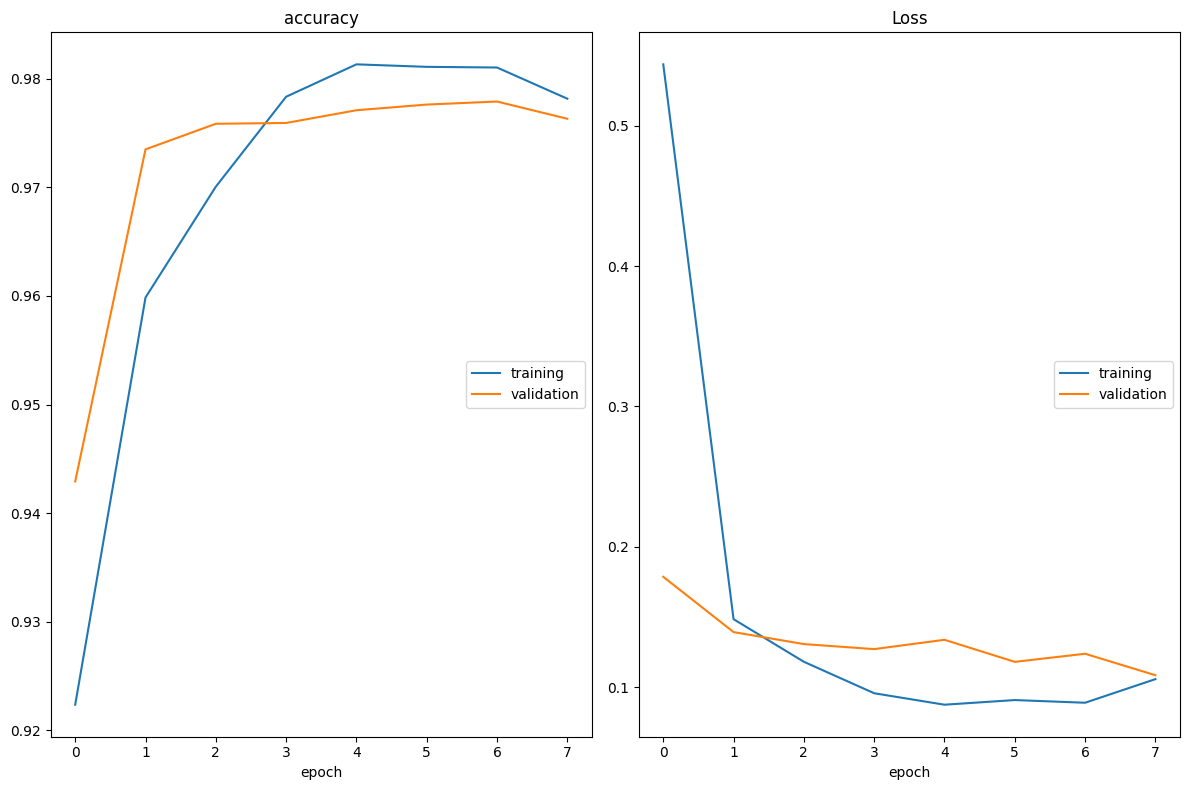

accuracy
	training         	 (min:    0.922, max:    0.981, cur:    0.978)
	validation       	 (min:    0.943, max:    0.978, cur:    0.976)
Loss
	training         	 (min:    0.087, max:    0.544, cur:    0.106)
	validation       	 (min:    0.109, max:    0.179, cur:    0.109)

Epoch 8: val_loss improved from 0.11801 to 0.10850, saving model to model_weights.h5
455/455 [==============================] - 139s 306ms/step - loss: 0.1057 - accuracy: 0.9782 - val_loss: 0.1085 - val_accuracy: 0.9763


In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback



logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]


history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=64,
    epochs=10,
    callbacks=callbacks,
    verbose=1

)